## Project Setup
Import libraries we will need and set up variables of urls. 

In [1]:
# all import statements needed for the project, for example:

import math
import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests
import sqlalchemy as db
import re
import random
import geopandas
import numpy as np

In [2]:
#Links and directories for downloading data, setting up variables that will be used thourghout the project
TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
UBER_CSV = "uber_rides_sample.csv"

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

## Part 1: Data Preprocessing 
In this part, we will clean and process three main data sets: 
1. Yellow taxi trips record, 
2. Uber rides records,
3. Historical Weather records
all collected from 2009/1/1 to 2015/6/30. 

We will aggregate data from different years into the same dataframe for later use, as well as adding and deleting columns to tailor dataframe for later analysis. 

### Calculating distance
Here we define two functions to do the following:
1. Write a function to calculate distance of 2 given location points with lattitude and longitude.
2. Write a function which adds a column named distance to trip records dataframe using the above calculate distance function. 

In [3]:
def calculate_distance(from_coord, to_coord):
     
    ''' Take in 2 coordinates with lattitudes and longtitudes
        Return a float variable named distance which is the distance of the 2 coordinates took in '''
    
    #calculate the difference between each lattitude and longtitude
    dlat = to_coord[0] - from_coord[0]
    dlon = to_coord[1] - from_coord[1]

    #use math formula to calculate the distance
    a = (math.sin(dlat/2))**2 + math.cos(from_coord[0]) * math.cos(to_coord[0]) * (math.sin(dlon/2))**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = 6371 * c
    
    return distance

In [4]:
def add_distance_column(dataframe):

    ''' Take in a dataframe
        Return a dataframe with additional column named distance '''

    #add a distance column to both uber and taxi files
    dis = []
    for i in range(len(dataframe.index)):
        dis.append(calculate_distance((dataframe.iloc[i]['PU_lat'],dataframe.iloc[i]['PU_lon']), (dataframe.iloc[i]['DO_lat'],dataframe.iloc[i]['DO_lon'])))
    
    dataframe.insert(len(dataframe.columns), "distance", dis)

### Processing Taxi Data

Here we download all taxi data files from website, clean the data by deleting the unnecessary columns and null inputs, add a new column named distance. 

Since all taxi trip data are grouped by months, we need to first write a function to obatain all downloading paths.

In [5]:
def find_taxi_csv_urls():

    '''Return a list including urls of all yellow taxi parquet files'''
    
    response = requests.get(TAXI_URL)
    soup = bs4.BeautifulSoup(response.content, 'html.parser')
    yellow_a_tags = soup.find_all("a", attrs={"title": "Yellow Taxi Trip Records"})
    yellow_taxis = [a["href"] for a in yellow_a_tags] # all yellow taxi trip records urls
    
    # creating a pattern to filter url name for desired time frame from 2009/1/1 to 2015/6/30
    pattern1 = re.compile(r"yellow_tripdata_2009-([0-9]{2}).parquet")
    pattern2 = re.compile(r"yellow_tripdata_201([0-4]{1})-([0-9]{2}).parquet")
    pattern3 = re.compile(r"yellow_tripdata_2015-0([1-6]{1}).parquet")
    
    filtered_taxi_files = []
    
    #finding all yellow taxi record urls from 2009/1/1 to 2015/6/30 and attached to result list
    for link in yellow_taxis:
        match = pattern1.search(link)
        if match:
            filtered_taxi_files.append(match.string)
    
    for link in yellow_taxis:
        match = pattern2.search(link)
        if match:
            filtered_taxi_files.append(match.string)
    
    for link in yellow_taxis:
        match = pattern3.search(link)
        if match:
            filtered_taxi_files.append(match.string)
    
    return filtered_taxi_files

After inspecting samples of some files, we noticed that some records have location ID instead of detail latitude and logitudes. In order to apply the add_distance_column(dataframe) function, we first need to download the taxi_zones file and use them to apply geopandas library. Then, we can have columns added to the datadframes as latitudes and longitudes like all other taxidataframes.

In [6]:
#read the taxi_zones geo files and extract the lat/log of the center point of each polygon
taxi_zones = "taxi_zones.shp"
zones = geopandas.read_file(taxi_zones)
zones = zones.to_crs(4326)
zones["lon"] = zones.centroid.x
zones["lat"] = zones.centroid.y
latitudes = zones.set_index('LocationID').to_dict()['lat']
longitudes = zones.set_index('LocationID').to_dict()['lon']

/tmp/ipykernel_8166/2233683682.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones["lon"] = zones.centroid.x
/tmp/ipykernel_8166/2233683682.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zones["lat"] = zones.centroid.y


Now moving to cleaning all taxi files in general, we write a function to take in a single file link, download it, and clean it to a standard version so that later we can append the cleaned dataframe to a final sample dataframe. Due to the large amount of data we have, we decided to sample each file to a size of 2500 such as all files adding up at the end will have an approximate size as the Uber data set. 

In [7]:
def get_and_clean_month_taxi_data(url):
   
    '''Take in an url, Return a sampled dataframe'''
    
    #download and read url into dataframe
    r = requests.get(url, stream = [True])
    file_name = ''.join(c for c in url if c.isdigit()) + "_yellowtaxi" #give the download file a name
    with open(file_name, 'wb') as f:
        f.write(r.content)  #downloading
    df = pd.read_parquet(file_name) #read into a dataframe
    
    if "PULocationID" in df.columns:
        df.insert(9, "PU_lon", df["PULocationID"].map(longitudes))
        df.insert(10, "PU_lat", df["PULocationID"].map(latitudes))
        df.insert(11, "DO_lon",df["DOLocationID"].map(longitudes))
        df.insert(12, "DO_lat", df["DOLocationID"].map(latitudes))
    
    #delete the unwanted columns and normalizing all columns names
    if "vendor_id" in df.columns:
        df.drop(['vendor_id', 'passenger_count', 'trip_distance', 'rate_code', 'store_and_fwd_flag', 'payment_type', 'fare_amount', 'surcharge', 'mta_tax','tolls_amount'], axis=1, inplace=True)
        df = df.rename(columns = {
            'pickup_datetime' : 'PU_datetime',
            'dropoff_datetime' : 'DO_datetime',
            'pickup_longitude' : 'PU_lon',
            'pickup_latitude' : 'PU_lat',
            'dropoff_longitude' : 'DO_lon',
            'dropoff_latitude' : 'DO_lat',
            'tip_amount' : 'tip_amt',
            'total_amount' : 'total_amt', 
        })
    if "vendor_name" in df.columns:
        df.drop(['vendor_name', 'Passenger_Count', 'Trip_Distance', 'Rate_Code', 'store_and_forward', 'Payment_Type', 'Fare_Amt', 'surcharge', 'mta_tax', 'Tolls_Amt' ], axis=1, inplace=True)
        df = df.rename(columns = {
            'Trip_Pickup_DateTime' : 'PU_datetime',
            'Trip_Dropoff_DateTime' : 'DO_datetime',
            'Start_Lon' : 'PU_lon',
            'Start_Lat' : 'PU_lat',
            'End_Lon' : 'DO_lon',
            'End_Lat' : 'DO_lat',
            'Tip_Amt' : 'tip_amt',
            'Total_Amt' : 'total_amt', 
        })
    if "VendorID" in df.columns:
        df.drop(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge', 'airport_fee'], axis=1, inplace=True)
        df = df.rename(columns = {
            'tpep_pickup_datetime' : 'PU_datetime',
            'tpep_dropoff_datetime' : 'DO_datetime',
            'tip_amount' : 'tip_amt',
            'total_amount' : 'total_amt', 
        })
        
    # delete any rows with null input
    df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
    
    # filter data to be within desire pick-up and drop-off locations
    df = df[(df['PU_lat']>40.560445) & (df['PU_lat']<40.908524)]
    df = df[(df['DO_lat']>40.560445) & (df['DO_lat']<40.908524)]
    df = df[(df['PU_lon']> -74.242330) & (df['PU_lon']< -73.717047)]
    df = df[(df['DO_lon']> -74.242330) & (df['DO_lon']< -73.717047)]
    
    
    #sample 2500 rows from each file
    df_sample = df.sample(2500)
    
    return df_sample

In [8]:
def get_and_clean_taxi_data():

    '''Return dataframe'''
    
    all_taxi_dataframes = []
    
    all_csv_urls = find_taxi_csv_urls()
    for csv_url in all_csv_urls:
        dataframe = get_and_clean_month_taxi_data(csv_url)
        add_distance_column(dataframe)
        
        
        all_taxi_dataframes.append(dataframe)
        
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)
    return taxi_data

### Processing Uber Data

In this part, we read uber data from cvs file. Then we clean data by deleting null values and unnecessary columns, filter the data by condition, and add a distance column to new dataframe. 

In [9]:
def load_and_clean_uber_data(csv_file):

    '''Take in cvs file, Return dataframe'''

    #read uber data from cvs file
    df = pd.read_csv(csv_file)

    #delete raws with null values
    df = df[~(df == 0).any(axis=1)]

    #filter data which lattitube in range(40.560445,40.908524) and longtitude in range(-74.242330，-73.717047)
    df = df[(df['pickup_latitude']>40.560445) & (df['pickup_latitude']<40.908524)]
    df = df[(df['dropoff_latitude']>40.560445) & (df['dropoff_latitude']<40.908524)]
    df = df[(df['pickup_longitude']> -74.242330) & (df['pickup_longitude']< -73.717047)]
    df = df[(df['dropoff_longitude']> -74.242330) & (df['dropoff_longitude']< -73.717047)]

    #rename the columns
    df = df.rename(columns = {
            'pickup_datetime' : 'PU_datetime',
            'pickup_longitude' : 'PU_lon',
            'pickup_latitude' : 'PU_lat',
            'dropoff_longitude' : 'DO_lon',
            'dropoff_latitude' : 'DO_lat',
        })

    #change the data type to datetime
    pd.to_datetime(df['PU_datetime'])
    
    #delete unnecessary columns
    del df['key']
    del df['Unnamed: 0']
    
    return df

In [10]:
def get_uber_data():

    '''Return dataframe'''
    
    uber_dataframe = load_and_clean_uber_data(UBER_CSV)
    add_distance_column(uber_dataframe)
    return uber_dataframe

### Processing Weather Data

Here we download the historical weather data and clean it such that we will have one dataframe with hourly records and one with daily records. Only a few columns are kept becasue we will only be using these in later analysis. 

In [11]:
def clean_month_weather_data_hourly(csv_file):
      
    '''Take in csv file, Return a dataframe'''
    
    #downloads csv file 
    df = pd.read_csv(csv_file, low_memory=False)

    #change the data type to datetime
    df['DATE'] = pd.to_datetime(df['DATE'])

    #select the specific columns we need 
    df = df[['DATE', 'HourlyDewPointTemperature', 'HourlyPrecipitation', 'HourlyWindSpeed']]

    #cleaning data with unknown inputs
    df.replace("T", 0.00, inplace=True)

    #changing  zeros to null so that we could delete them 
    df.replace(0.00, np.nan, inplace=True)
    df.dropna(how ="any", inplace = True)
    
    return df

In [12]:
def clean_month_weather_data_daily(csv_file):
     
    '''Take in csv file, Return a dataframe'''
    
    #downloads csv file 
    df = pd.read_csv(csv_file, low_memory=False)

    #change the data type to datetime
    df['DATE'] = pd.to_datetime(df['DATE'])

    #select the specific columns we need 
    df = df[['DATE','HourlyPrecipitation', 'HourlyWindSpeed']]

    #clean the data with unknow input and changing data type to numbers
    df.replace("T", 0, inplace=True)
    df['HourlyPrecipitation'] = df['HourlyPrecipitation'].str.rstrip('s')
    df['HourlyPrecipitation'] = pd.to_numeric(df['HourlyPrecipitation'])
    df['HourlyWindSpeed'] = pd.to_numeric(df['HourlyWindSpeed'])

    #calculate daily input with houly records if missing
    df1 = df.groupby([df['DATE'].dt.date])['HourlyPrecipitation'].sum()
    df2 = df.groupby([df['DATE'].dt.date])['HourlyWindSpeed'].mean()
    
    df3 = pd.read_csv(csv_file, low_memory=False)
    df3['DATE'] = pd.to_datetime(df3['DATE'])
    df3 = df3[['DATE','DailyAverageDewPointTemperature', 'DailySustainedWindSpeed']]
    df3 = df3.groupby([df3['DATE'].dt.date]).sum()
    
    #creating the final daily record file
    frame = [df1, df2, df3]
    df4 = pd.concat(frame, axis = 1)
    df4 = df4.rename(columns = {'HourlyPrecipitation' : 'DailyPrecipitation',
                               'HourlyWindSpeed' : 'DailyWindSpeed'
                               })
    df4.replace(np.nan, 0.00, inplace=True)
    
    return df4

Now we process all weather data files.

In [13]:
def load_and_clean_weather_data():
     
    '''Return two dataframes'''
    
    hourly_dataframes = []
    daily_dataframes = []
    
    #all the files we need 
    weather_csv_files = ["2009_weather.csv", "2010_weather.csv", "2011_weather.csv", "2012_weather.csv", "2013_weather.csv", 
                        "2014_weather.csv", "2015_weather.csv"]
    
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    return hourly_data, daily_data

### Process All Data

Here we finally execute all the required functions to obatin dataframes from above.

In [14]:
taxi_data = get_and_clean_taxi_data()
uber_data = get_uber_data()
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

/tmp/ipykernel_8166/4013154513.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df3 = df3.groupby([df3['DATE'].dt.date]).sum()
/tmp/ipykernel_8166/4013154513.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df3 = df3.groupby([df3['DATE'].dt.date]).sum()
/tmp/ipykernel_8166/4013154513.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df3 = df3.groupby([df3['DATE'].dt.date]).sum()
/tmp/ipykernel_8166/4013154513.

## Part 2: Storing Cleaned Data

In part 2, we create a database based on the data we processed in part 1. We use sqlalchemy and sqlite3 to achive it. 

In [15]:
engine = db.create_engine(DATABASE_URL)

In [16]:
# to create our 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather(
   hourly_weatherId INTEGER PRIMARY KEY AUTOINCREMENT,
   DATE DATE,
   HourlyDewPointTemperature FLOAT,
   HourlyPrecipitation FLOAT
   HourlyWindSpeed FLOAT
)
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather(
   daily_weatherId INTEGER PRIMARY KEY AUTOINCREMENT,
   DATE DATE,
   DailyPrecipitation FLOAT,
   DailyWindSpeed FLOAT
   DailyAverageDewPointTemperature FLOAT
   DailySustainedWindSpeed FLOAT
)
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips(
   taxi_tripsId INTEGER PRIMARY KEY AUTOINCREMENT,
   PU_datetime DATE,
   DO_datetime DATE,
   PU_lon FLOAT
   PU_lat FLOAT
   DO_lon FLOAT
   DO_lat FLOAT
   tip_amt FLOAT
   total_amt FLOAT
   distance FLOAT
)
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips(
   uber_tripsId INTEGER PRIMARY KEY AUTOINCREMENT,
   fare_amount FLOAT
   PU_datetime DATE,
   PU_lon FLOAT
   PU_lat FLOAT
   DO_lon FLOAT
   DO_lat FLOAT
   passenger_count INTEGER
   distance FLOAT
)
"""


In [17]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [18]:
# create the tables with the schema files
with engine.connect() as connection:
    pass

### Add Data to Database

We create database above and we want to add our data processed in part 1 into the database. 

In [19]:
def write_dataframes_to_table(table_to_df_dict):
    '''Takes in a dictionary that has table name as key and data as value'''
    for table_name, df in table_to_df_dict.items():
        df.to_sql(table_name, engine, if_exists='replace', index=False)

In [21]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
}

In [22]:
#executing
write_dataframes_to_table(map_table_name_to_dataframe)

## Part 3: Understanding the Data
We analyze the data we obtained above by answering these 6 questions. 

First define a function to read in a query and download as a sql file.

In [23]:
def write_query_to_file(query, outfile):
    '''Take in a query and an outfile name; download query data with outfile as file name'''
    with open(outfile, "w") as f:
        f.write(query)

### Query 1

_**TODO:** For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi?_


In [24]:
## most popular hour of the day to take a yellow taxi
QUERY_1 = """
SELECT strftime('%H', PU_datetime) AS hour, COUNT(*) AS num
FROM taxi_trips
GROUP BY hour

ORDER BY num DESC
"""

In [25]:
engine.execute(QUERY_1).fetchall()

[('19', 12195),
 ('18', 11667),
 ('20', 11391),
 ('21', 11080),
 ('22', 10900),
 ('17', 9820),
 ('14', 9763),
 ('23', 9650),
 ('13', 9468),
 ('15', 9445),
 ('12', 9411),
 ('09', 9103),
 ('10', 8997),
 ('08', 8925),
 ('11', 8897),
 ('16', 8038),
 ('00', 7779),
 ('07', 7117),
 ('01', 5855),
 ('02', 4335),
 ('06', 3909),
 ('03', 3039),
 ('04', 2258),
 ('05', 1958)]

In [26]:
write_query_to_file(QUERY_1, "most_popular_taxi_hour.sql")

### Query 2

_**TODO:** For the same time frame, what day of the week was the most popular to take an uber?_


In [27]:
QUERY_2 = """
SELECT strftime('%w', PU_datetime) As weekday, COUNT(*) AS num
FROM uber_trips
GROUP BY weekday

ORDER BY num DESC;
"""

In [28]:
engine.execute(QUERY_2).fetchall()

[(None, 194785)]

In [29]:
write_query_to_file(QUERY_2, "most_popular_uber_day.sql")

### Query 3

_**TODO:** What is the 95% percentile of distance traveled for all hired trips during July 2013?_

In [30]:
## the 95% percentile of distance traveled for all hired trips during July 2013
QUERY_3 = """
WITH all_hired_trips AS(
SELECT PU_datetime, distance FROM taxi_trips WHERE PU_datetime BETWEEN "2013-07-01" AND "2013-07-31"
UNION ALL
SELECT PU_datetime, distance FROM uber_trips WHERE PU_datetime BETWEEN "2013-07-01" AND "2013-07-31")

SELECT distance FROM all_hired_trips
ORDER BY distance ASC

LIMIT 1
OFFSET (SELECT COUNT(*) FROM all_hired_trips) * 95 / 100;
"""


In [31]:
engine.execute(QUERY_3).fetchall()

[(686.5299386448987,)]

In [32]:
write_query_to_file(QUERY_3, "95th Percentile of distance Jul13.sql")

### Query 4

_**TODO:** What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?_

In [33]:
#the top 10 days with the highest number of hired rides for 2009, and the average distance for each day?
QUERY_4 = """WITH all_hired_trips AS (
SELECT PU_datetime, distance FROM taxi_trips WHERE PU_datetime BETWEEN '2009-01-01' AND '2009-12-31'
UNION ALL
SELECT PU_datetime,distance FROM uber_trips WHERE PU_datetime BETWEEN '2009-01-01' AND '2009-12-31')

SELECT PU_datetime AS date, AVG(distance) AS avg_dist, COUNT(*) AS num
FROM all_hired_trips

GROUP BY date
ORDER BY num DESC

LIMIT 10;
"""

In [34]:
engine.execute(QUERY_4).fetchall()

[('2009-02-12 12:46:00 UTC', 185.56812489967436, 4),
 ('2009-11-05 23:39:00 UTC', 319.44367818660373, 3),
 ('2009-10-20 22:00:00 UTC', 105.36049225794368, 3),
 ('2009-09-15 08:42:00', 149.22162254817684, 3),
 ('2009-09-11 12:43:00 UTC', 67.00548194557821, 3),
 ('2009-07-31 20:12:00 UTC', 161.67367501911653, 3),
 ('2009-07-17 14:18:00', 343.62325972894905, 3),
 ('2009-06-04 21:01:00 UTC', 218.30692956962966, 3),
 ('2009-06-02 16:33:00', 98.13264056931602, 3),
 ('2009-05-31 18:23:00 UTC', 117.945251678395, 3)]

In [35]:
write_query_to_file(QUERY_4, "top 10 most rides 2009.sql")

### Query 5

_**TODO:** Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?_

In [36]:
#top 10 windest days in 2014, and number of hired trips on those days
QUERY_5 ="""
SELECT date(PU_datetime) AS date, COUNT(*) AS num

FROM(SELECT PU_datetime FROM taxi_trips
UNION ALL
SELECT PU_datetime FROM uber_trips)

GROUP BY date
HAVING date IN (SELECT DATE FROM daily_weather WHERE DATE BETWEEN '2014-01-01' AND '2014-12-31'
ORDER BY DailyWindSpeed DESC)

LIMIT 10
"""

In [37]:
engine.execute(QUERY_5).fetchall()

[('2014-01-01', 71),
 ('2014-01-02', 69),
 ('2014-01-03', 46),
 ('2014-01-04', 81),
 ('2014-01-05', 72),
 ('2014-01-06', 74),
 ('2014-01-07', 78),
 ('2014-01-08', 82),
 ('2014-01-09', 85),
 ('2014-01-10', 95)]

In [38]:
write_query_to_file(QUERY_5, "top 10 windest day 2014.sql")

### Query 6

_**TODO:** During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?_

In [39]:
#During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, 
#trips taken each hour, and for each hour, the amount of precipitation in NYC and the sustained wind speed
QUERY_6 = """
WITH all_hired_trips AS (
SELECT strftime('%H',PU_datetime) AS date FROM taxi_trips WHERE PU_datetime BETWEEN '2012-10-22' AND '2012-11-06'
UNION ALL
SELECT strftime('%H',PU_datetime) FROM uber_trips WHERE PU_datetime BETWEEN '2012-10-22' AND '2012-11-07')

SELECT strftime('%H', hourly_weather.DATE) AS weekday, COALESCE(COUNT(all_hired_trips.date),0) AS num, HourlyPrecipitation, HourlyWindSpeed FROM hourly_weather

LEFT JOIN all_hired_trips ON weekday WHERE weekday BETWEEN '2012-10-22' AND '2012-11-06'

GROUP BY weekday
"""

In [40]:
engine.execute(QUERY_6).fetchall()

[]

In [41]:
write_query_to_file(QUERY_6, "Hurricane days weather and rides.sql")

## Part 4: Visualizing the Data

Here we plot 6 graphs to help readers analyze the above data.

### Visualization 1

_Visualization demonstrating the numbers of trips in each hour of the day through 1/1/2009 - 6/1/2015_


<AxesSubplot: title={'center': 'Number of ride in each hour of the day through 1/1/2009 - 6/1/2015'}, xlabel='Hour of the day', ylabel='number of rides'>

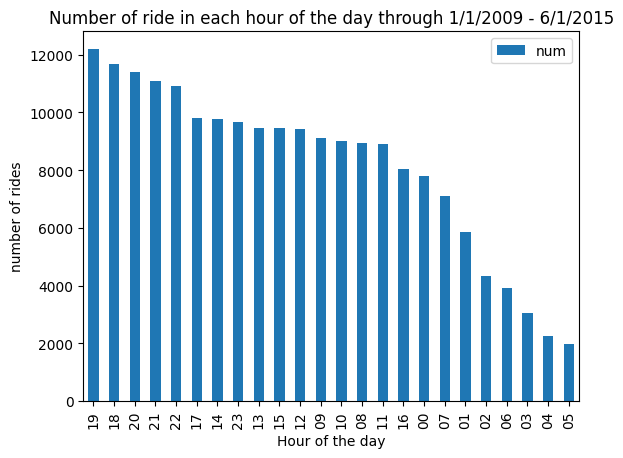

In [42]:
#read the query from before into dataframe
df = pd.read_sql_query(QUERY_1, engine)

#producing a bar chart
df.plot.bar(x='hour', y='num', title = "Number of ride in each hour of the day through 1/1/2009 - 6/1/2015", xlabel = "Hour of the day", ylabel = "number of rides")

### Visualization 2

_Visualization demonstrating the average distance traveled per month and 95% confidence interval_


Text(0, 0.5, 'Average Distance of Rides')

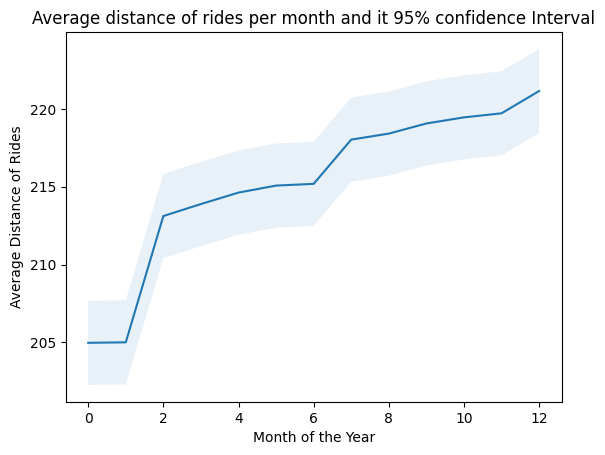

In [43]:
#use query to select and merge average distance by datetime column from two tables
QUERY_avg_dis = """
WITH all_hired_trips AS (
SELECT strftime('%m', PU_datetime) AS month, AVG(distance) AS dis FROM taxi_trips
GROUP BY month
UNION ALL
SELECT strftime('%m', PU_datetime) AS month, AVG(distance) AS dis FROM uber_trips)

SELECT dis FROM all_hired_trips

ORDER BY dis ASC
"""


#read the query into dataframe
df = pd.read_sql_query(QUERY_avg_dis, engine)

#find the 95% interval range (one side)
ci = 1.96 * np.std(df['dis'])/np.sqrt(len(df.index))

#producing a graph with line and shaded area indicating the 95% interval
fig, ax = plt.subplots()
ax.plot(df.index,df['dis'])
ax.fill_between(df.index, (df['dis']-ci), (df['dis']+ci), alpha=.1)
ax.set_title("Average distance of rides per month and it 95% confidence Interval")
ax.set_xlabel("Month of the Year")
ax.set_ylabel("Average Distance of Rides")

### Visualization 3

_Visualization to compare what day of the week was most popular for drop offs for each airport: JFK, LGA, EWR_


We first obtain the latitude and longtitudes of the three airports using BBOX. 
However we did not acheive to produce a visualization for this question. 
Our thought process is that to query from a union of the drop off locations of taxi trips and uber trips that are in these three airport polygon. Select weekday from datetime and group by weekday to see which day of the week has most rides to these airport. 
Then producing a bar chart to visualize the trends. 

In [44]:
jfk = ["-73.875160", "40.598965", "-73.627968", "40.705758"]
lga = ['-73.889236','40.767412', '-73.855419', '40.786131'] 
ewr = ['-74.192305','40.670288','-73.855419','40.786131']



### Visualization 4

_Create a heatmap of all hired trips over a map of the area._


In [45]:
# Firstly, we write a query to obtain dataframe of all pickup locations. 
QUERY_PUlocation = '''
WITH all_hired_trips AS(
SELECT PU_lat AS lat, PU_lon AS lon FROM taxi_trips 
UNION ALL
SELECT PU_lat AS lat, PU_lon AS lon FROM uber_trips)

SELECT lat, lon
FROM all_hired_trips
'''
df = pd.read_sql_query(QUERY_PUlocation, engine)

### Visualization 5

_Visualization comparing tip amount versus distance._


<AxesSubplot: title={'center': 'tip amount vs trip distance for all taxi trips'}, xlabel='Tip Amount', ylabel='Trip Distance'>

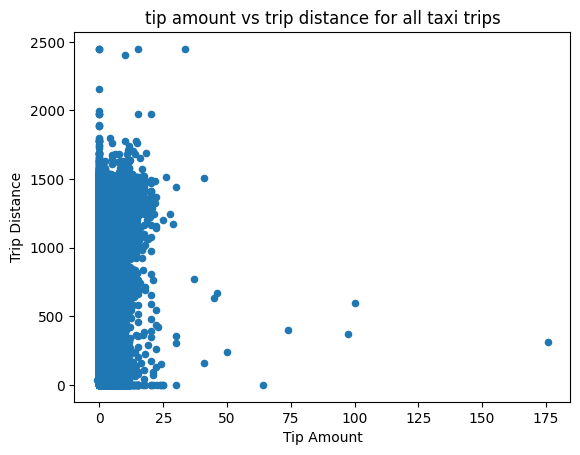

In [46]:
#use query to select tips and distance columns from taxi_trips table
QUERY_tip_dis = """
SELECT tip_amt AS tips, distance AS dis FROM taxi_trips
"""
#read the query into dataframe
df = pd.read_sql_query(QUERY_tip_dis, engine)
#obtain a small sample for a better visual
df.sample(1000)
#producing a scatter plot
df.plot.scatter(x='tips', y='dis', title = "tip amount vs trip distance for all taxi trips", xlabel = "Tip Amount", ylabel = "Trip Distance")

### Visualization 6

_Visualization comparing tip amount versus precipitation amount._


<AxesSubplot: title={'center': 'Hourly Precipitation vs Tip Amount'}, xlabel='Hourly Precipitation', ylabel='Tip Amount'>

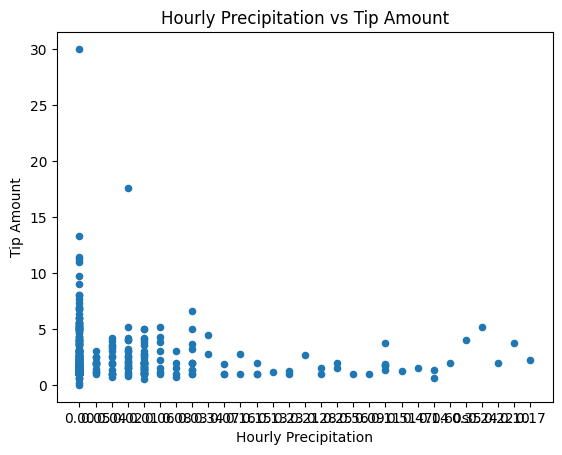

In [47]:
#use query to select the columns we need from each table 
QUERY_tips ="""SELECT strftime('%H', PU_datetime) AS hour, tip_amt FROM taxi_trips""" 
QUERY_prec ="""SELECT strftime('%H', DATE) AS hour, HourlyPrecipitation FROM hourly_weather"""

#read the query into two dataframes
tips_data = pd.read_sql_query(QUERY_tips, engine)
precipitation_data = pd.read_sql_query(QUERY_prec, engine)

#obtain a smaller sample from each dataset
tips_data = tips_data.sample(10000)
precipitation_data =  precipitation_data.sample(10000)
#merge the two by the same hour records
df = pd.merge(tips_data, precipitation_data, on = 'hour')

#obtain a small sample for a better visual
df = df.sample(1000)
#drop rows with zero tip or zero precipitation
df = df[(df[['tip_amt','HourlyPrecipitation']] != 0).all(axis=1)]
#producing a scatter plot
df.plot.scatter(x="HourlyPrecipitation", y="tip_amt", title="Hourly Precipitation vs Tip Amount", xlabel = "Hourly Precipitation", ylabel = "Tip Amount")